In [33]:
# Install libraries...
# !pip install torch torchvision ftfy regex tqdm
# !pip install open_clip_torch

## Calculating Cosine Similarity Between Text and Images
In this demo, we leverage the cosine_similarity function to assess the similarity between a given text query and a series of images. This function utilizes the ViT-B-32 model from the open_clip library, specifically trained with the laion2b_s34b_b79k dataset. Our objective is to encode the text and images into vectors in a shared space where their similarity can be quantitatively measured.

The cosine_similarity function first tokenizes the input text using open_clip's tokenizer and preprocesses the images through a provided preprocessing pipeline. These preprocessed inputs are then passed to the ViT-B-32 model to generate embeddings, or high-dimensional vectors, that represent the text and images in a manner that allows for comparison.

Following the generation of embeddings, the function normalizes these vectors to unit length and computes their dot product. The dot product in this normalized space equates to the cosine similarity between the text and each image, effectively measuring how similar the content of the text is to the visual content of the images. Cosine similarity scores range from -1 (completely different) to 1 (identical), with higher scores indicating greater similarity.

In [97]:
import torch
from PIL import Image
import open_clip
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


def plot_images(filenames):
    """
    Plots a list of images specified by their filenames horizontally.

    Args:
    - filenames (list of str): The list of image filenames to be plotted.

    Displays:
    - A horizontal array of the images.
    """
    # Set up the figure
    fig, axs = plt.subplots(1, len(filenames), figsize=(len(filenames) * 5, 5))
    
    # If only one image, axs might not be an array
    if len(filenames) == 1:
        axs = [axs]
    
    for ax, filename in zip(axs, filenames):
        # Load the image
        img = Image.open(filename)
        # Display the image
        ax.imshow(img)
        # Remove the axis ticks
        ax.axis('off')

        ax.set_title(filename.split('/')[-1], fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()


def cosine_similarity(query, image_files):
    """
    Computes cosine similarity scores between a text query and a list of images.

    This function uses the ViT-B-32 model from open_clip with a specific pretrained
    version to encode both the text and images into vectors. It then computes the
    cosine similarity between the text vector and each image vector.

    Parameters:
    - query (str): The text query for comparison.
    - images (list of str): A list of file paths to the images for comparison.

    Note:
    - Requires the 'open_clip' and 'torch' libraries.
    """

    # Load the model, tokenizer, and preprocessing function for ViT-B-32.
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')

    # Tokenize the text query.
    text = tokenizer([query])

    # Process images and stack them into a single tensor.
    images = torch.cat([preprocess(Image.open(image_file)).unsqueeze(0) for image_file in image_files])

    with torch.no_grad(), torch.cuda.amp.autocast():
        # Encode images and text, then normalize the feature vectors.
        image_features = model.encode_image(images)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Compute cosine similarity as dot product of normalized vectors.
        similarity = text_features @ image_features.T

    print("COSINE SIMILARITY RESULTS:")
    for filename, score in zip(image_files, similarity.tolist()[0]):
        print(f"\t{filename}: {round(score, 3)}")



To demonstrate, we define a text query and a list of images:

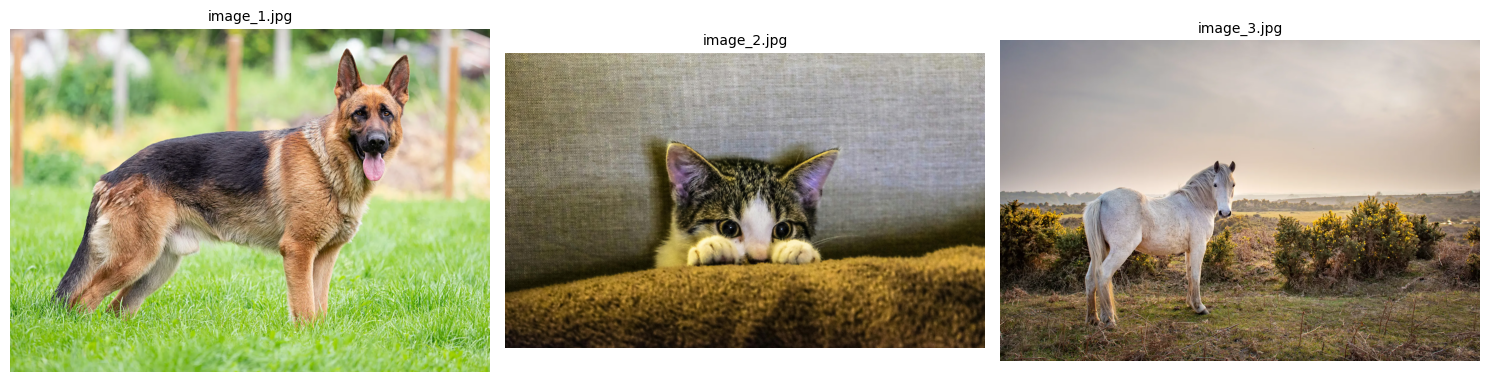

In [95]:
query = "a kitten"
images = ["image_1.jpg", "image_2.jpg", "image_3.jpg"]

plot_images(images)

This script outputs the similarity scores between our query, "a kitten", and each of the images in the list. These scores help us understand which images are most visually relevant to the text query.

In [98]:
cosine_similarity(query, images)

COSINE SIMILARITY RESULTS:
	image_1.jpg: 0.112
	image_2.jpg: 0.297
	image_3.jpg: 0.052
